# 0. Imports

In [8]:
from pipeline.load_activations import prepare_dataloaders
import torch
import torch.nn as nn
import gc
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from einops import einsum
from torch.utils.data import Dataset, DataLoader

In [9]:
def get_start_pos(token_ids: torch.Tensor) -> int:
    im_start_token = 151644
    im_start_positions = (token_ids == im_start_token).nonzero(as_tuple=True)[0]
    return im_start_positions[1].item()

## 1. Progress bar trajectories

In [ ]:
train_dataloader, test_dataloader, stats = prepare_dataloaders(
        activations_dir="/workspace/llm-progress-monitor/rollouts-big/activations",
        batch_size=1024,
        test_size=0.01,
        end_idx = 2000,
        shuffle = True
    )

### linear to predict linear

In [ ]:
all_acts = []
all_n_remaining = []

In [ ]:
for activations, n_remaining, n_total in train_dataloader:
    all_acts.append(activations.to('cuda', dtype=torch.float32))
    all_n_remaining.append(n_remaining.to('cuda', dtype=torch.float32))

all_acts = torch.cat(all_acts)
all_n_remaining = torch.cat(all_n_remaining)


In [ ]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ all_n_remaining
linear_to_linear_betas = torch.linalg.solve(XTX, XTy)

In [ ]:
linear_to_linear_betas.shape

In [ ]:
torch.save(linear_to_linear_betas, '/workspace/final_write_up/linear_to_linear_betas.pt')

### linear to predict log

In [ ]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ (all_n_remaining + 1).log()
linear_to_log_betas = torch.linalg.solve(XTX, XTy)
torch.save(linear_to_log_betas, '/workspace/final_write_up/linear_to_log_betas.pt')

In [ ]:
del all_acts, all_n_remaining, linear_to_linear_betas, linear_to_log_betas

gc.collect()
torch.cuda.empty_cache()

### bins classifier

In [74]:
class LogBinClassifer(nn.Module):
    def __init__(self, input_dim: int, n_bins: int):
        super().__init__()
        self.n_bins = n_bins
        self.linear = nn.Linear(input_dim, n_bins)

    def forward(self, x):
        return self.linear(x)

In [75]:
n_bins = 11
def bin_y(y):
    return (y+1).log().floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

In [ ]:
model = LogBinClassifer(2560, 10).to('cuda')
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
loss_fn = CrossEntropyLoss()

In [ ]:
n_epochs = 3
for epoch in range(n_epochs):
    for activations, n_remaining, n_total in train_dataloader:
        optimizer.zero_grad()
        pred = model(activations.to('cuda', dtype=torch.float32))
        n_remaining_binned = bin_y(n_remaining)
        loss = loss_fn(pred, n_remaining_binned)
        loss.backward()
        optimizer.step()
        print(loss.item())
        

In [ ]:
torch.save(model.state_dict(), '/workspace/llm-progress-monitor/final_write_up/log_bin_classifier.pt')

### using the randomly sampled from each sequence

In [ ]:
import random

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import threading

def load_and_sample_activations(i):
    token_ids, activations = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/activations/{i}.pt')
    start_pos = get_start_pos(token_ids)
    activations = activations[:, start_pos:].to('cuda')
    token_ids = token_ids.to('cuda')

    n_remaining = activations.shape[-2] - torch.arange(activations.shape[-2], device=activations.device)
    # Randomly sample 200 indices from the sequence
    random_indices = random.sample(range(activations.shape[-2]), min(200, activations.shape[-2]))
    random_indices = torch.tensor(random_indices, device=activations.device)
    chosen_activations = activations[:,random_indices]
    chosen_n_remaining = n_remaining[random_indices]
    print(f'{i} done')
    return chosen_activations, chosen_n_remaining

all_chosen_activations = []
all_chosen_n_remaining = []

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(load_and_sample_activations, range(2000)))

for chosen_activations, chosen_n_remaining in results:
    all_chosen_activations.append(chosen_activations[0])
    all_chosen_n_remaining.append(chosen_n_remaining)

all_chosen_activations = torch.cat(all_chosen_activations)
all_chosen_n_remaining = torch.cat(all_chosen_n_remaining)



In [ ]:
all_chosen_activations = all_chosen_activations.to('cuda', dtype=torch.float32)
all_chosen_n_remaining = all_chosen_n_remaining.to('cuda', dtype=torch.float32)


In [ ]:
XtX = all_chosen_activations.T @ all_chosen_activations
XTy = all_chosen_activations.T @ all_chosen_n_remaining

lin_to_lin_betas = torch.linalg.solve(XtX, XTy)

In [ ]:
torch.save(lin_to_lin_betas, '/workspace/final_write_up/balanced_lin_to_lin_betas.pt')

In [ ]:
XTy = all_chosen_activations.T @ (all_chosen_n_remaining + 1).log()
lin_to_log_betas = torch.linalg.solve(XtX, XTy)
torch.save(lin_to_log_betas, '/workspace/final_write_up/balanced_lin_to_log_betas.pt')

In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, all_chosen_activations, all_chosen_n_remaining):
        self.all_chosen_activations = all_chosen_activations
        self.all_chosen_n_remaining = all_chosen_n_remaining

    def __len__(self):
        return len(self.all_chosen_activations)
    
    def __getitem__(self, idx):
        return self.all_chosen_activations[idx], self.all_chosen_n_remaining[idx]
    
train_dataset = BalancedDataset(all_chosen_activations, all_chosen_n_remaining)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
model = LogBinClassifer(2560, 10).to('cuda')

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = CrossEntropyLoss()

In [ ]:
n_epochs = 1
for epoch in range(n_epochs):
    for activations, n_remaining in train_dataloader:
        optimizer.zero_grad()
        pred = model(activations.to('cuda', dtype=torch.float32))
        n_remaining_binned = bin_y(n_remaining)
        loss = loss_fn(pred, n_remaining_binned)
        loss.backward()
        optimizer.step()
        print(loss.item())
    
        


In [ ]:
torch.save(model.state_dict(), '/workspace/llm-progress-monitor/final_write_up/balanced_log_bin_classifier.pt')

### eval on test prompts

In [76]:
def sequence_to_pred_n_remaining_lin_to_lin(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].clamp(min=0) # s
    return pred_n_remaining

In [77]:
def sequence_to_pred_n_remaining_lin_to_log(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].exp() # s
    return pred_n_remaining

In [78]:
def sequence_to_pred_n_remaining_classifier(sequence: torch.Tensor, classifier: nn.Module) -> torch.Tensor:
    logits = classifier(sequence[0].to('cuda', dtype=torch.float32))
    probs = torch.softmax(logits, dim=1)
    n_bins = probs.shape[1]
    pred_n_remaining = torch.sum(probs * torch.arange(n_bins, device=logits.device), dim=1).exp()
    return pred_n_remaining

In [79]:
def pred_n_remaining_to_percent_estimate(pred_n_remaining: torch.Tensor) -> torch.Tensor:
    token_number = torch.arange(pred_n_remaining.shape[0], device=pred_n_remaining.device) 
    n_remaining_percent = token_number / (token_number + pred_n_remaining)
    return n_remaining_percent


In [80]:
model = LogBinClassifer(2560, 10).to('cuda')
model.load_state_dict(torch.load('/workspace/llm-progress-monitor/final_write_up/log_bin_classifier.pt'))
balanced_model = LogBinClassifer(2560, 10).to('cuda')
balanced_model.load_state_dict(torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_log_bin_classifier.pt'))


<All keys matched successfully>

In [81]:
(model.linear.weight - balanced_model.linear.weight)

tensor([[ 0.0278, -0.0361,  0.0284,  ..., -0.0406, -0.0242,  0.0005],
        [ 0.0082, -0.0544,  0.0162,  ..., -0.0025, -0.0007, -0.0084],
        [ 0.0452, -0.0731,  0.0155,  ..., -0.0088, -0.0059, -0.0093],
        ...,
        [-0.0110,  0.0541, -0.0297,  ..., -0.0059, -0.0281,  0.0022],
        [-0.0027,  0.0100, -0.0297,  ...,  0.0197, -0.0015,  0.0641],
        [-0.0029, -0.0425, -0.0553,  ..., -0.0033, -0.0392,  0.0703]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [128]:
def process_sequence(i):
    try:
        token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/test/activations/{i}.pt')
        sequence = sequence.to('cuda')
        start_pos = get_start_pos(token_ids)
        sequence = sequence[:, start_pos+10:]
        actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
        lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_linear_betas.pt').to('cuda', dtype = torch.bfloat16)
        lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
        balanced_lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_lin_betas.pt').to('cuda', dtype = torch.bfloat16)
        balanced_lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
        lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, lin_to_lin_betas)
        log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, lin_to_log_betas)
        balanced_lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, balanced_lin_to_lin_betas)
        balanced_log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, balanced_lin_to_log_betas)
        classifier_pred_n_remaining = sequence_to_pred_n_remaining_classifier(sequence, model)
        balanced_classifier_pred_n_remaining = sequence_to_pred_n_remaining_classifier(sequence, balanced_model)
        lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(lin_pred_n_remaining)
        log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(log_pred_n_remaining)
        balanced_lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_lin_pred_n_remaining)
        balanced_log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_log_pred_n_remaining)
        balanced_classifier_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_classifier_pred_n_remaining)
        classifier_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(classifier_pred_n_remaining)

        return {
            'lin_to_lin_percent': lin_pred_n_remaining_percent,
            'lin_to_log_percent': log_pred_n_remaining_percent,
            'log_bin_classifier_percent': classifier_pred_n_remaining_percent,
            'balanced_lin_to_lin_percent': balanced_lin_pred_n_remaining_percent,
            'balanced_lin_to_log_percent': balanced_log_pred_n_remaining_percent,
            'balanced_log_bin_classifier_percent': balanced_classifier_pred_n_remaining_percent,
            'lin_to_lin_log': (lin_pred_n_remaining + 1).log(),
            'lin_to_log_log': (log_pred_n_remaining + 1).log(),
            'log_bin_classifier_log': (classifier_pred_n_remaining + 1).log(),
            'balanced_lin_to_lin_log': (balanced_lin_pred_n_remaining + 1).log(),
            'balanced_lin_to_log_log': (balanced_log_pred_n_remaining + 1).log(),
            'balanced_log_bin_classifier_log': (balanced_classifier_pred_n_remaining + 1).log(),
            'actual_n_remaining': actual_n_remaining,
            'log_n_tokens_remaining': (actual_n_remaining + 1).log(),
        }
    except Exception as e:
        print(f"Error processing sequence {i}: {e}")
        return None

# Initialize lists
all_pred_percent_estimates = {'lin_to_lin': [None] * 1000, 'lin_to_log': [None] * 1000, 'log_bin_classifier': [None] * 1000, 'balanced_lin_to_lin': [None] * 1000, 'balanced_lin_to_log': [None] * 1000, 'balanced_log_bin_classifier': [None] * 1000}
all_actual_n_remaining = [None] * 1000
all_log_pred_estimates = {'lin_to_lin': [None] * 1000, 'lin_to_log': [None] * 1000, 'log_bin_classifier': [None] * 1000, 'balanced_lin_to_lin': [None] * 1000, 'balanced_lin_to_log': [None] * 1000, 'balanced_log_bin_classifier': [None] * 1000}
all_log_n_tokens_remaining = [None] * 1000

# Process sequences (can be parallelized)
from concurrent.futures import ThreadPoolExecutor
import threading

def process_and_store(i):
    try:
        result = process_sequence(i)
        if result is not None:
            all_pred_percent_estimates['lin_to_lin'][i] = result['lin_to_lin_percent']
            all_pred_percent_estimates['lin_to_log'][i] = result['lin_to_log_percent']
            all_pred_percent_estimates['log_bin_classifier'][i] = result['log_bin_classifier_percent']
            all_pred_percent_estimates['balanced_lin_to_lin'][i] = result['balanced_lin_to_lin_percent']
            all_pred_percent_estimates['balanced_lin_to_log'][i] = result['balanced_lin_to_log_percent']
            all_pred_percent_estimates['balanced_log_bin_classifier'][i] = result['balanced_log_bin_classifier_percent']
            all_log_pred_estimates['lin_to_lin'][i] = result['lin_to_lin_log']
            all_log_pred_estimates['lin_to_log'][i] = result['lin_to_log_log']
            all_log_pred_estimates['log_bin_classifier'][i] = result['log_bin_classifier_log']
            all_log_pred_estimates['balanced_lin_to_lin'][i] = result['balanced_lin_to_lin_log']
            all_log_pred_estimates['balanced_lin_to_log'][i] = result['balanced_lin_to_log_log']
            all_log_pred_estimates['balanced_log_bin_classifier'][i] = result['balanced_log_bin_classifier_log']
            all_actual_n_remaining[i] = result['actual_n_remaining']
            all_log_n_tokens_remaining[i] = result['log_n_tokens_remaining']
        print(f"Processed {i}")
    except Exception as e:
        print(f"Error in process_and_store for sequence {i}: {e}")

# Run in parallel
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_and_store, range(1000))


Processed 0
Processed 2
Processed 1
Processed 3
Processed 4
Processed 6
Processed 7
Processed 5
Processed 8
Processed 10
Processed 9
Processed 11
Processed 12
Processed 14
Processed 13
Processed 15
Processed 16
Processed 17
Processed 18
Processed 19
Processed 20
Processed 21
Processed 22
Processed 23
Processed 24
Processed 25
Processed 26
Processed 27
Processed 28
Processed 29
Processed 30
Processed 31
Processed 32
Processed 33
Processed 34
Processed 35
Processed 36
Processed 37
Processed 38
Processed 39
Processed 40
Processed 42
Processed 41
Processed 43
Processed 44
Processed 46
Processed 45
Processed 47
Processed 48
Processed 50
Processed 49
Processed 51
Processed 52
Processed 53
Processed 54
Processed 56
Processed 55
Processed 57
Processed 58
Processed 59
Processed 60
Processed 61
Processed 62
Processed 64
Processed 63
Processed 66
Processed 65
Processed 67
Processed 68
Processed 70
Processed 69
Processed 71
Processed 72
Processed 73
Processed 74
Processed 75
Processed 76
Processed

In [83]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_pred_percent_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_pred_percent_estimates[model_type])):
        actual = 1-(all_actual_n_remaining[i]/len(all_actual_n_remaining[i])).float().detach().cpu().numpy()
        predicted = all_pred_percent_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(actual, predicted, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    # Filter out NaN values
    all_actual_array = np.array(all_actual)
    all_predicted_array = np.array(all_predicted)
    
    # Create mask for non-NaN values
    mask = ~(np.isnan(all_actual_array) | np.isnan(all_predicted_array))
    
    # Calculate R2 only on non-NaN values
    r2 = r2_score(all_actual_array[mask], all_predicted_array[mask])
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Actual n_remaining')
    plt.ylabel('Predicted n_remaining')
    plt.show()
    
    plt.savefig(f'/workspace/llm-progress-monitor/final_write_up/plots/{model_type}.png')


## 2. predicted n_tokens_remaining vs actual R^2 for good and bad data mix (and logistic classifiers on each of these)

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(predicted, actual, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    
    
    plt.savefig(f'/workspace/llm-progress-monitor/final_write_up/plots/{model_type}_log.png')
    plt.show()


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation (median idx only)
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        # Take only the median index for each sequence
        median_idx = len(actual) // 2
        all_actual.append(actual[median_idx])
        all_predicted.append(predicted[median_idx])
        
        plt.scatter(predicted[median_idx], actual[median_idx], alpha=0.5, s=10, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} - Median Only (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    
    # Save before show() to avoid saving a blank figure
    plt.savefig(f'/workspace/llm-progress-monitor/final_write_up/plots/{model_type}_log_median.png')
    plt.show()



Progress point: 0.10
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for model lin_to_log: index -1 is out of bounds for dimension 0 with size 0
Error in progress point 0.10 for 

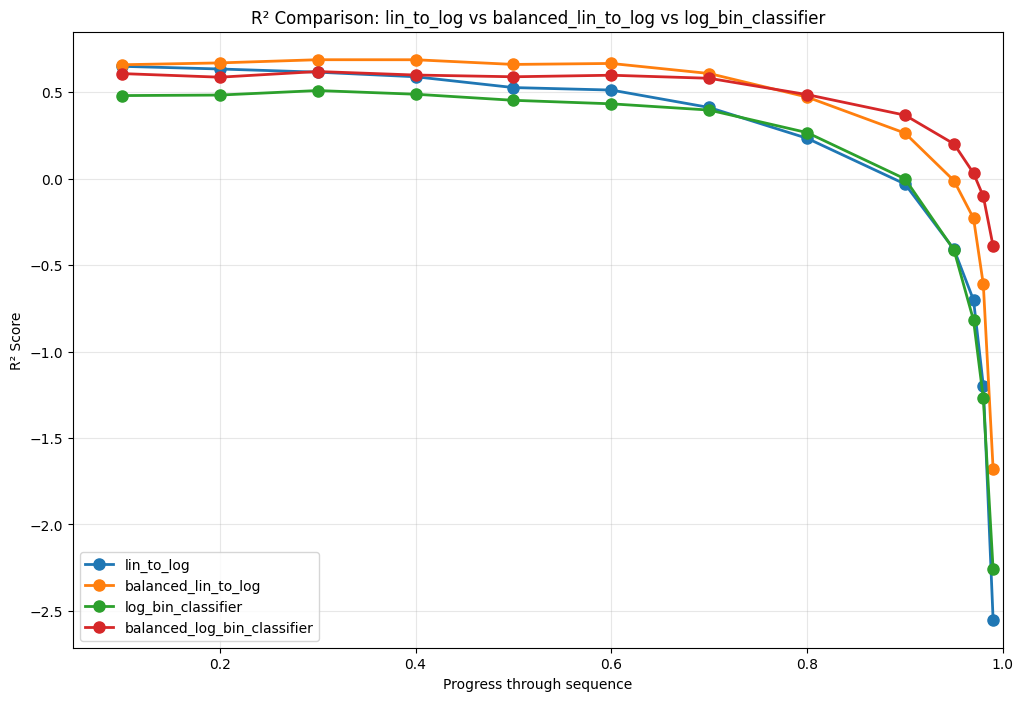

In [ ]:
from sklearn.metrics import r2_score
import numpy as np
import torch
# Compare lin_to_log, balanced_lin_to_log, and log_bin_classifier at different progress points
progress_points = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.98,0.99]
model_types = ['lin_to_log', 'balanced_lin_to_log', 'log_bin_classifier', 'balanced_log_bin_classifier']

results = {model_type: [] for model_type in model_types}

for progress in progress_points:
    print(f"\nProgress point: {progress:.2f}")
    
    for model_type in model_types:
        if model_type not in all_log_pred_estimates:
            continue
            
        all_actual = []
        all_predicted = []
        
        for i in range(len(all_log_pred_estimates[model_type])):
            actual = all_log_n_tokens_remaining[i].float()
            predicted = all_log_pred_estimates[model_type][i].float()
            
            # Calculate the index for this progress point
            progress_idx = int(len(actual) * progress)
            if progress_idx >= len(actual):
                progress_idx = len(actual) - 1
                
            all_actual.append(actual[progress_idx].detach().cpu().numpy())
            all_predicted.append(predicted[progress_idx].detach().cpu().numpy())
        
        # Calculate R2
        r2 = r2_score(all_actual, all_predicted)
        results[model_type].append(r2)
        print(f"{model_type}: R² = {r2:.4f}")

# Plot comparison
plt.figure(figsize=(12, 8))
for model_type in model_types:
    if model_type in results and results[model_type]:
        plt.plot(progress_points, results[model_type], marker='o', linewidth=2, markersize=8, label=model_type)

plt.xlabel('Progress through sequence')
plt.ylabel('R² Score')
plt.title('R² Comparison: lin_to_log vs balanced_lin_to_log vs log_bin_classifier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.05, 1.0)


plt.savefig('/workspace/llm-progress-monitor/final_write_up/plots/r2_comparison_progress.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def ema_tensor(tensor, alpha=0.9):
    """
    Apply Exponential Moving Average to a tensor.
    
    Args:
        tensor: Input tensor of shape (sequence_length,)
        alpha: Smoothing factor (0 < alpha < 1)
    
    Returns:
        Tensor with EMA applied
    """
    n = len(tensor)
    
    # Create the EMA transformation matrix
    # Each row i has alpha^(i-j) * (1-alpha) for j <= i, 0 for j > i
    # Except the first row which is [1, 0, 0, ...]
    ema_matrix = torch.zeros(n, n, device=tensor.device, dtype=tensor.dtype)
    
    # First row is just [1, 0, 0, ...]
    ema_matrix[0, 0] = 1.0
    
    # For subsequent rows - vectorized construction
    i_indices = torch.arange(1, n, device=tensor.device).unsqueeze(1)
    j_indices = torch.arange(n, device=tensor.device).unsqueeze(0)
    
    # Create mask for valid positions (j <= i)
    mask = j_indices <= i_indices
    
    # Create diagonal mask (j == i)
    diag_mask = j_indices == i_indices
    
    # Calculate values: alpha^(i-j) * (1-alpha) for off-diagonal, (1-alpha) for diagonal
    powers = alpha ** (i_indices - j_indices)
    values = torch.where(diag_mask, 1 - alpha, powers * (1 - alpha))
    
    # Apply mask and assign to matrix
    ema_matrix[1:, :] = torch.where(mask, values, 0.0).to(tensor.device)
    # Apply the transformation
    return torch.matmul(ema_matrix, tensor)

# Apply EMA to the tensor
smoothed_log_pred_estimates = [ema_tensor(all_log_pred_estimates[model_type][i], alpha=0.5) for i in range(len(all_log_pred_estimates[model_type]))]


=== Alpha = 0.5 ===

Progress point: 0.10
balanced_lin_to_log: R² = 0.6603
smoothed_log_pred_estimates: R² = 0.6719

Progress point: 0.20
balanced_lin_to_log: R² = 0.6739
smoothed_log_pred_estimates: R² = 0.6577

Progress point: 0.30
balanced_lin_to_log: R² = 0.6842
smoothed_log_pred_estimates: R² = 0.6679

Progress point: 0.40
balanced_lin_to_log: R² = 0.6755
smoothed_log_pred_estimates: R² = 0.6632

Progress point: 0.50
balanced_lin_to_log: R² = 0.6610
smoothed_log_pred_estimates: R² = 0.6459

Progress point: 0.60
balanced_lin_to_log: R² = 0.6348
smoothed_log_pred_estimates: R² = 0.6217

Progress point: 0.70
balanced_lin_to_log: R² = 0.5969
smoothed_log_pred_estimates: R² = 0.5996

Progress point: 0.80
balanced_lin_to_log: R² = 0.4875
smoothed_log_pred_estimates: R² = 0.5261

Progress point: 0.90
balanced_lin_to_log: R² = 0.2729
smoothed_log_pred_estimates: R² = 0.3781

Progress point: 0.95
balanced_lin_to_log: R² = -0.0027
smoothed_log_pred_estimates: R² = 0.1666

Progress point: 0

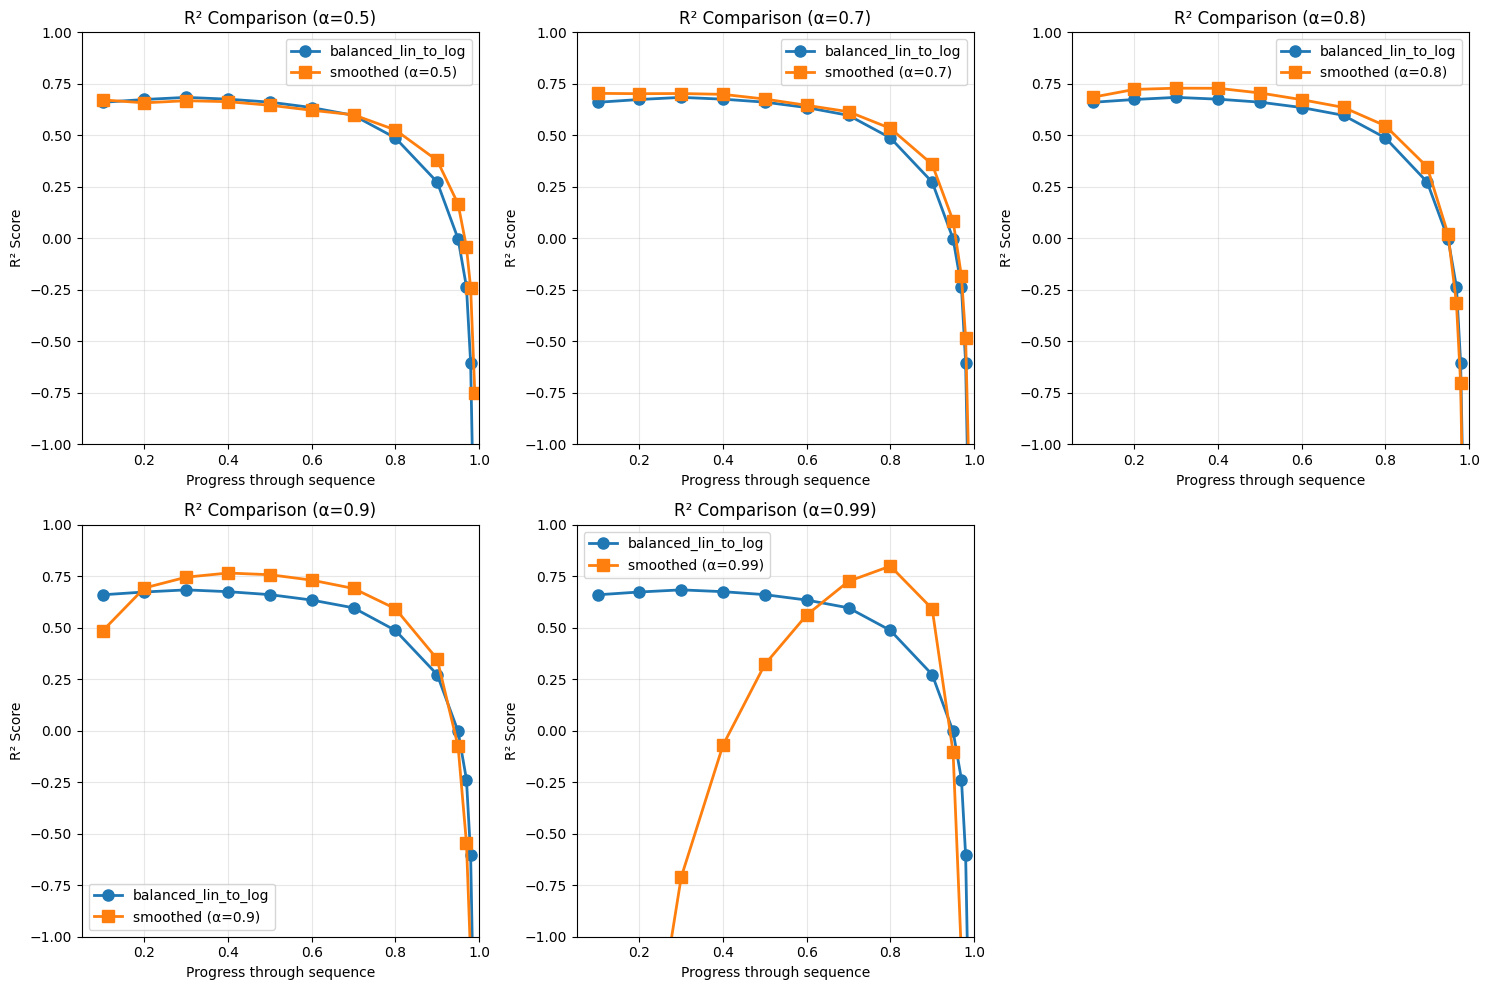

IndexError: list index out of range

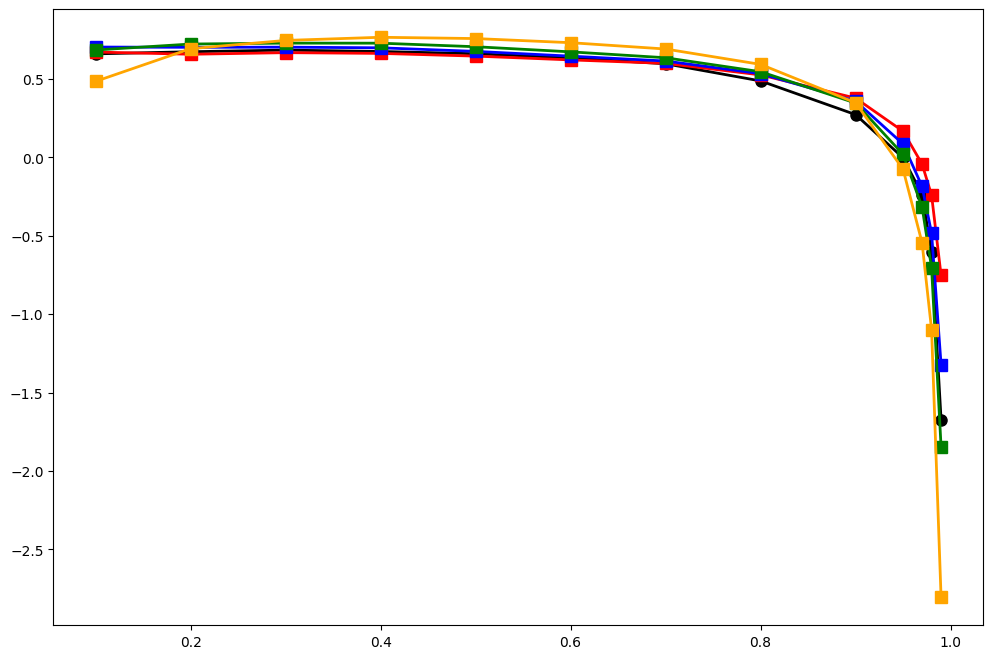

In [130]:
# Compare balanced_lin_to_log against smoothed_log_pred_estimates at different progress points
progress_points = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99]
alpha_values = [0.5, 0.7, 0.8, 0.9, 0.99]

# Store results for each alpha
all_results = {}

for alpha in alpha_values:
    print(f"\n=== Alpha = {alpha} ===")
    
    # Apply EMA with current alpha
    smoothed_log_pred_estimates = [ema_tensor(all_log_pred_estimates[model_type][i], alpha=alpha) for i in range(len(all_log_pred_estimates[model_type]))]
    
    results = {'balanced_lin_to_log': [], 'smoothed_log_pred_estimates': []}
    
    for progress in progress_points:
        print(f"\nProgress point: {progress:.2f}")
        
        all_actual = []
        all_predicted_balanced = []
        all_predicted_smoothed = []
        
        for i in range(len(all_log_pred_estimates['balanced_lin_to_log'])):
            actual = all_log_n_tokens_remaining[i].float()
            predicted_balanced = all_log_pred_estimates['balanced_lin_to_log'][i].float()
            predicted_smoothed = smoothed_log_pred_estimates[i].float()
            
            # Calculate the index for this progress point
            progress_idx = int(len(actual) * progress)
            if progress_idx >= len(actual):
                progress_idx = len(actual) - 1
                
            all_actual.append(actual[progress_idx].detach().cpu().numpy())
            all_predicted_balanced.append(predicted_balanced[progress_idx].detach().cpu().numpy())
            all_predicted_smoothed.append(predicted_smoothed[progress_idx].detach().cpu().numpy())
        
        # Calculate R2 for both models
        r2_balanced = r2_score(all_actual, all_predicted_balanced)
        r2_smoothed = r2_score(all_actual, all_predicted_smoothed)
        
        results['balanced_lin_to_log'].append(r2_balanced)
        results['smoothed_log_pred_estimates'].append(r2_smoothed)
        
        print(f"balanced_lin_to_log: R² = {r2_balanced:.4f}")
        print(f"smoothed_log_pred_estimates: R² = {r2_smoothed:.4f}")
    
    all_results[alpha] = results

# Plot comparison for all alpha values
plt.figure(figsize=(15, 10))

# Create subplots for each alpha
for i, alpha in enumerate(alpha_values):
    plt.subplot(2, 3, i+1)
    results = all_results[alpha]
    
    plt.plot(progress_points, results['balanced_lin_to_log'], marker='o', linewidth=2, markersize=8, label='balanced_lin_to_log')
    plt.plot(progress_points, results['smoothed_log_pred_estimates'], marker='s', linewidth=2, markersize=8, label=f'smoothed (α={alpha})')
    
    plt.xlabel('Progress through sequence')
    plt.ylabel('R² Score')
    plt.title(f'R² Comparison (α={alpha})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0.05, 1.0)
    plt.ylim(-1.0,1.0)

plt.tight_layout()
plt.savefig('/workspace/llm-progress-monitor/final_write_up/plots/r2_comparison_balanced_vs_smoothed_all_alphas.png', dpi=300, bbox_inches='tight')
plt.show()

# Also create a single plot showing smoothed results for all alphas
plt.figure(figsize=(12, 8))

# Plot balanced_lin_to_log once
plt.plot(progress_points, all_results[alpha_values[0]]['balanced_lin_to_log'], marker='o', linewidth=2, markersize=8, label='balanced_lin_to_log', color='black')

# Plot smoothed results for each alpha
colors = ['red', 'blue', 'green', 'orange']
for i, alpha in enumerate(alpha_values):
    results = all_results[alpha]
    plt.plot(progress_points, results['smoothed_log_pred_estimates'], marker='s', linewidth=2, markersize=8, 
             label=f'smoothed (α={alpha})', color=colors[i])

plt.xlabel('Progress through sequence')
plt.ylabel('R² Score')
plt.title('R² Comparison: balanced_lin_to_log vs smoothed_log_pred_estimates (all α values)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.05, 1.0)
plt.ylim(-1.0,1.0)

plt.savefig('/workspace/llm-progress-monitor/final_write_up/plots/r2_comparison_all_alphas_combined.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
all_log_pred_estimates['balanced_lin_to_log'][0]

tensor([6.3125, 6.0312, 6.7812,  ..., 2.8750, 2.3281, 2.5000], device='cuda:0',
       dtype=torch.bfloat16)

In [84]:
log_bin_weights = model.linear.weight

In [85]:
log_bin_weights.shape

torch.Size([10, 2560])

In [ ]:
lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
        

In [ ]:
cosine_similarities = torch.cosine_similarity(lin_to_log_betas.float().unsqueeze(0), log_bin_weights.float(), dim=1)

# Fit -sin(x) to the cosine similarities
from scipy.optimize import curve_fit
import numpy as np

def neg_sin_func(x, amplitude, frequency, phase, offset):
    return -amplitude * np.sin(frequency * x + phase) + offset

x_data = np.arange(len(cosine_similarities))
y_data = cosine_similarities.detach().cpu().numpy()

# Initial guess for parameters: amplitude, frequency, phase, offset
initial_guess = [0.5, 2*np.pi/len(x_data), 0, np.mean(y_data)]

try:
    popt, _ = curve_fit(neg_sin_func, x_data, y_data, p0=initial_guess)
    amplitude, frequency, phase, offset = popt
    
    # Generate fitted curve
    x_fit = np.linspace(0, len(cosine_similarities)-1, 200)
    y_fit = neg_sin_func(x_fit, *popt)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(cosine_similarities)), y_data, alpha=0.7, label='Data')
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, 
             label=f'-sin fit: amp={amplitude:.3f}, freq={frequency:.3f}')
    plt.xlabel('Bin Index')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity between lin_to_log_betas and log_bin_weights')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Fitted parameters:")
    print(f"Amplitude: {amplitude:.4f}")
    print(f"Frequency: {frequency:.4f}")
    print(f"Phase: {phase:.4f}")
    print(f"Offset: {offset:.4f}")
    
except Exception as e:
    print(f"Fitting failed: {e}")
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(cosine_similarities)), y_data)
    plt.xlabel('Bin Index')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity between lin_to_log_betas and log_bin_weights')
    plt.grid(True, alpha=0.3)
    plt.show()


In [113]:
# Get PCA of the model weights
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

# Assuming we have the model weights in log_bin_weights
# log_bin_weights should be shape [n_bins, hidden_dim]
print(f"log_bin_weights shape: {log_bin_weights.shape}")

# Convert to numpy for PCA
weights_np = log_bin_weights.detach().cpu().numpy()

# Perform PCA
pca = PCA(n_components=3)
weights_pca = pca.fit_transform(weights_np)

print(f"PCA weights shape: {weights_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Also transform the betas to PCA space
lin_to_log_betas_np = lin_to_log_betas.float().detach().cpu().numpy()
betas_pca = pca.transform(lin_to_log_betas_np.reshape(1, -1))

# Create 3D scatter plot with Plotly
fig = go.Figure()

# Add scatter points for weights
fig.add_trace(go.Scatter3d(
    x=weights_pca[:, 0],
    y=weights_pca[:, 1],
    z=weights_pca[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=np.arange(len(weights_pca)),
        colorscale='viridis',
        colorbar=dict(title="Bin Index"),
        showscale=True
    ),
    name='Model Weights',
    text=[f'Bin {i}' for i in range(len(weights_pca))],
    hovertemplate='<b>%{text}</b><br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<br>PC3: %{z:.3f}<extra></extra>'
))

# Add arrow vector for betas (from origin to beta point)
fig.add_trace(go.Scatter3d(
    x=[0, betas_pca[0, 0]],
    y=[0, betas_pca[0, 1]],
    z=[0, betas_pca[0, 2]],
    mode='lines+markers',
    line=dict(color='red', width=8),
    marker=dict(size=[0, 10], color=['red', 'red']),
    name='lin_to_log_betas',
    hovertemplate='<b>Betas Vector</b><br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<br>PC3: %{z:.3f}<extra></extra>'
))

# Add cone for arrow head
fig.add_trace(go.Cone(
    x=[betas_pca[0, 0]],
    y=[betas_pca[0, 1]],
    z=[betas_pca[0, 2]],
    u=[betas_pca[0, 0] * 0.1],
    v=[betas_pca[0, 1] * 0.1],
    w=[betas_pca[0, 2] * 0.1],
    colorscale='Reds',
    showscale=False,
    name='Beta Direction'
))

fig.update_layout(
    title='PCA of Model Weights with lin_to_log_betas Vector',
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.3f})',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.3f})',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.3f})',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=800,
    height=600
)

fig.show()

# Also create 2D projections with arrows
fig_2d = make_subplots(
    rows=1, cols=3,
    subplot_titles=['PC1 vs PC2', 'PC1 vs PC3', 'PC2 vs PC3'],
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]]
)

# PC1 vs PC2
fig_2d.add_trace(go.Scatter(
    x=weights_pca[:, 0],
    y=weights_pca[:, 1],
    mode='markers',
    marker=dict(color=np.arange(len(weights_pca)), colorscale='viridis', size=8),
    name='Weights',
    showlegend=False
), row=1, col=1)

fig_2d.add_trace(go.Scatter(
    x=[0, betas_pca[0, 0]],
    y=[0, betas_pca[0, 1]],
    mode='lines+markers',
    line=dict(color='red', width=3),
    marker=dict(size=[0, 10], color='red'),
    name='Betas',
    showlegend=False
), row=1, col=1)

# PC1 vs PC3
fig_2d.add_trace(go.Scatter(
    x=weights_pca[:, 0],
    y=weights_pca[:, 2],
    mode='markers',
    marker=dict(color=np.arange(len(weights_pca)), colorscale='viridis', size=8),
    name='Weights',
    showlegend=False
), row=1, col=2)

fig_2d.add_trace(go.Scatter(
    x=[0, betas_pca[0, 0]],
    y=[0, betas_pca[0, 2]],
    mode='lines+markers',
    line=dict(color='red', width=3),
    marker=dict(size=[0, 10], color='red'),
    name='Betas',
    showlegend=False
), row=1, col=2)

# PC2 vs PC3
fig_2d.add_trace(go.Scatter(
    x=weights_pca[:, 1],
    y=weights_pca[:, 2],
    mode='markers',
    marker=dict(color=np.arange(len(weights_pca)), colorscale='viridis', size=8),
    name='Weights',
    showlegend=False
), row=1, col=3)

fig_2d.add_trace(go.Scatter(
    x=[0, betas_pca[0, 1]],
    y=[0, betas_pca[0, 2]],
    mode='lines+markers',
    line=dict(color='red', width=3),
    marker=dict(size=[0, 10], color='red'),
    name='Betas',
    showlegend=False
), row=1, col=3)

fig_2d.update_xaxes(title_text=f'PC1 ({pca.explained_variance_ratio_[0]:.3f})', row=1, col=1)
fig_2d.update_yaxes(title_text=f'PC2 ({pca.explained_variance_ratio_[1]:.3f})', row=1, col=1)
fig_2d.update_xaxes(title_text=f'PC1 ({pca.explained_variance_ratio_[0]:.3f})', row=1, col=2)
fig_2d.update_yaxes(title_text=f'PC3 ({pca.explained_variance_ratio_[2]:.3f})', row=1, col=2)
fig_2d.update_xaxes(title_text=f'PC2 ({pca.explained_variance_ratio_[1]:.3f})', row=1, col=3)
fig_2d.update_yaxes(title_text=f'PC3 ({pca.explained_variance_ratio_[2]:.3f})', row=1, col=3)

fig_2d.update_layout(
    title_text='2D PCA Projections with lin_to_log_betas Vectors',
    width=1200,
    height=400
)

fig_2d.show()


log_bin_weights shape: torch.Size([10, 2560])
PCA weights shape: (10, 3)
Explained variance ratio: [0.4415573  0.17454548 0.11676399]
Total explained variance: 0.7329


## 3. n_tokens before < / think>

In [137]:
from transformers import AutoTokenizer

In [138]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B")

In [140]:
balanced_lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)

In [171]:
positions_before_think = [1,5] + list(range(10, 100, 10))
decreases_to_think = {position_before_think: [] for position_before_think in positions_before_think}
decreases_baseline = {position_before_think: [] for position_before_think in positions_before_think}
for i in range(100):
    token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/test/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_pos = get_start_pos(token_ids)
    sequence = sequence[:, start_pos:]
    token_ids = token_ids[start_pos:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    think_end_token = tokenizer.encode("</think>")[0]
    think_end_index = (token_ids == think_end_token).nonzero(as_tuple=True)[0][0].item()
    balanced_log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, balanced_lin_to_log_betas)
    for position_before_think in positions_before_think:
        if position_before_think < think_end_index and think_end_index > 5:
            decreases_to_think[position_before_think].append( balanced_log_pred_n_remaining[think_end_index] - balanced_log_pred_n_remaining[think_end_index - position_before_think])
            # take the average of all pairs of distance position_before_think apart i.e. replace think index with position_before_think to len(sequence)
            decreases_baseline[position_before_think].append(balanced_log_pred_n_remaining[position_before_think:].mean() - balanced_log_pred_n_remaining[:-position_before_think].mean())

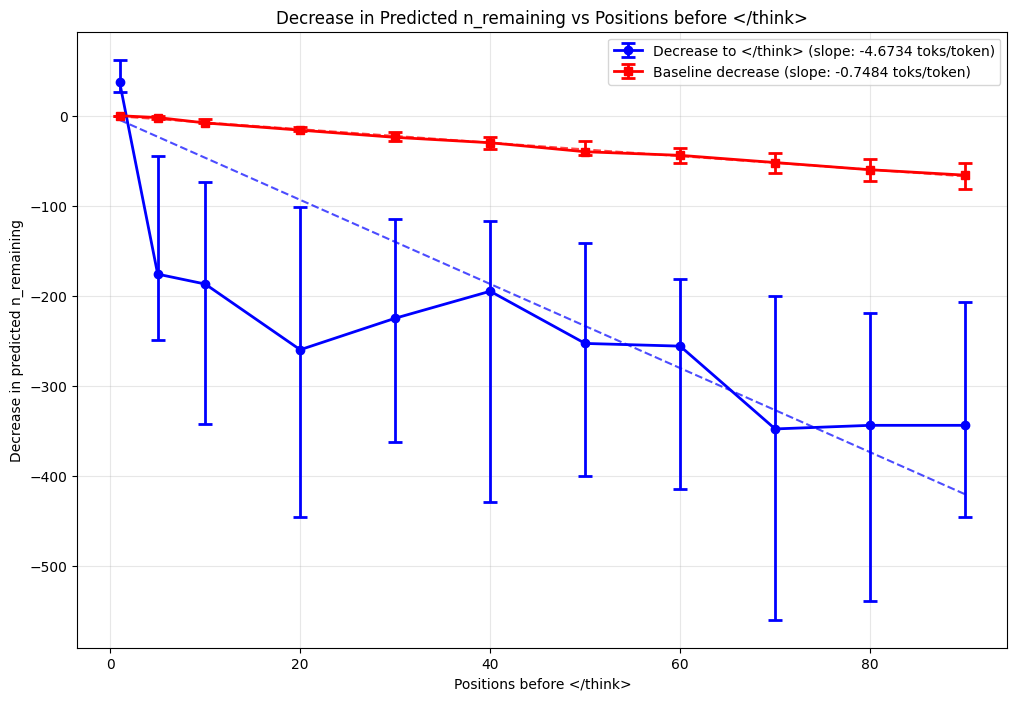

Slope for decrease to </think>: -4.673386 toks/token
Slope for baseline decrease: -0.748440 toks/token


In [173]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare data for plotting with error bars using median and percentiles
positions = list(decreases_to_think.keys())
decreases_to_think_medians = []
decreases_to_think_25th = []
decreases_to_think_75th = []
decreases_baseline_medians = []
decreases_baseline_25th = []
decreases_baseline_75th = []

for pos in positions:
    # Calculate medians and percentiles for decreases to think
    think_values = torch.stack(decreases_to_think[pos]).float()
    decreases_to_think_medians.append(torch.median(think_values).item())
    decreases_to_think_25th.append(torch.quantile(think_values, 0.25).item())
    decreases_to_think_75th.append(torch.quantile(think_values, 0.75).item())
    
    # Calculate medians and percentiles for baseline decreases
    baseline_values = torch.stack(decreases_baseline[pos]).float()
    decreases_baseline_medians.append(torch.median(baseline_values).item())
    decreases_baseline_25th.append(torch.quantile(baseline_values, 0.25).item())
    decreases_baseline_75th.append(torch.quantile(baseline_values, 0.75).item())

# Calculate error bars (distance from median to 25th/75th percentiles)
think_lower_err = [med - q25 for med, q25 in zip(decreases_to_think_medians, decreases_to_think_25th)]
think_upper_err = [q75 - med for med, q75 in zip(decreases_to_think_medians, decreases_to_think_75th)]
baseline_lower_err = [med - q25 for med, q25 in zip(decreases_baseline_medians, decreases_baseline_25th)]
baseline_upper_err = [q75 - med for med, q75 in zip(decreases_baseline_medians, decreases_baseline_75th)]

# Fit linear regression (no bias) to both lines
X = np.array(positions).reshape(-1, 1)
y_think = np.array(decreases_to_think_medians)
y_baseline = np.array(decreases_baseline_medians)

# Fit linear regression without intercept (through origin)
reg_think = LinearRegression(fit_intercept=False)
reg_baseline = LinearRegression(fit_intercept=False)

reg_think.fit(X, y_think)
reg_baseline.fit(X, y_baseline)

# Get slopes (in toks/token)
slope_think = reg_think.coef_[0]
slope_baseline = reg_baseline.coef_[0]

# Create the plot with error bars showing 25th-75th percentile range
plt.figure(figsize=(12, 8))
plt.errorbar(positions, decreases_to_think_medians, 
             yerr=[think_lower_err, think_upper_err],
             marker='o', linewidth=2, markersize=6, capsize=5, capthick=2,
             label=f'Decrease to </think> (slope: {slope_think:.4f} toks/token)', color='blue')
plt.errorbar(positions, decreases_baseline_medians, 
             yerr=[baseline_lower_err, baseline_upper_err],
             marker='s', linewidth=2, markersize=6, capsize=5, capthick=2,
             label=f'Baseline decrease (slope: {slope_baseline:.4f} toks/token)', color='red')

# Plot regression lines
x_line = np.linspace(min(positions), max(positions), 100)
plt.plot(x_line, reg_think.predict(x_line.reshape(-1, 1)), '--', color='blue', alpha=0.7)
plt.plot(x_line, reg_baseline.predict(x_line.reshape(-1, 1)), '--', color='red', alpha=0.7)

plt.xlabel('Positions before </think>')
plt.ylabel('Decrease in predicted n_remaining')
plt.title('Decrease in Predicted n_remaining vs Positions before </think>')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Slope for decrease to </think>: {slope_think:.6f} toks/token")
print(f"Slope for baseline decrease: {slope_baseline:.6f} toks/token")

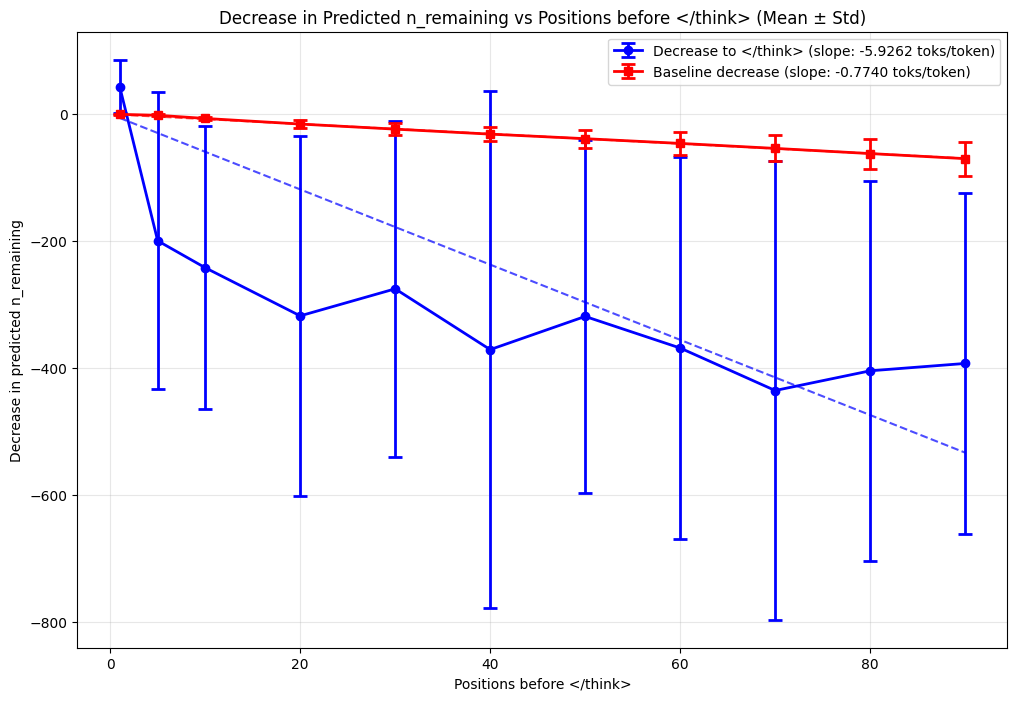

Slope for decrease to </think>: -5.926155 toks/token
Slope for baseline decrease: -0.774014 toks/token


In [174]:
# Prepare data for plotting with error bars using mean and standard deviation
positions = list(decreases_to_think.keys())
decreases_to_think_means = []
decreases_to_think_stds = []
decreases_baseline_means = []
decreases_baseline_stds = []

for pos in positions:
    # Calculate means and standard deviations for decreases to think
    think_values = torch.stack(decreases_to_think[pos]).float()
    decreases_to_think_means.append(torch.mean(think_values).item())
    decreases_to_think_stds.append(torch.std(think_values).item())
    
    # Calculate means and standard deviations for baseline decreases
    baseline_values = torch.stack(decreases_baseline[pos]).float()
    decreases_baseline_means.append(torch.mean(baseline_values).item())
    decreases_baseline_stds.append(torch.std(baseline_values).item())

# Fit linear regression (no bias) to both lines
X = np.array(positions).reshape(-1, 1)
y_think = np.array(decreases_to_think_means)
y_baseline = np.array(decreases_baseline_means)

# Fit linear regression without intercept (through origin)
reg_think = LinearRegression(fit_intercept=False)
reg_baseline = LinearRegression(fit_intercept=False)

reg_think.fit(X, y_think)
reg_baseline.fit(X, y_baseline)

# Get slopes (in toks/token)
slope_think = reg_think.coef_[0]
slope_baseline = reg_baseline.coef_[0]

# Create the plot with error bars showing standard deviation
plt.figure(figsize=(12, 8))
plt.errorbar(positions, decreases_to_think_means, 
             yerr=decreases_to_think_stds,
             marker='o', linewidth=2, markersize=6, capsize=5, capthick=2,
             label=f'Decrease to </think> (slope: {slope_think:.4f} toks/token)', color='blue')
plt.errorbar(positions, decreases_baseline_means, 
             yerr=decreases_baseline_stds,
             marker='s', linewidth=2, markersize=6, capsize=5, capthick=2,
             label=f'Baseline decrease (slope: {slope_baseline:.4f} toks/token)', color='red')

# Plot regression lines
x_line = np.linspace(min(positions), max(positions), 100)
plt.plot(x_line, reg_think.predict(x_line.reshape(-1, 1)), '--', color='blue', alpha=0.7)
plt.plot(x_line, reg_baseline.predict(x_line.reshape(-1, 1)), '--', color='red', alpha=0.7)

plt.xlabel('Positions before </think>')
plt.ylabel('Decrease in predicted n_remaining')
plt.title('Decrease in Predicted n_remaining vs Positions before </think> (Mean ± Std)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Slope for decrease to </think>: {slope_think:.6f} toks/token")
print(f"Slope for baseline decrease: {slope_baseline:.6f} toks/token")


## 4. R2 of predicted tokens with EMA = 0.9 and EMA = 0

show here that we do not benefit from more data

# 5. EMA of residual stream in 3-D with PCA. Try find rotation

In [2]:
import torch, numpy as np, matplotlib.pyplot as plt

In [3]:
lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_linear_betas.pt').to('cuda', dtype = torch.bfloat16)
lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
balanced_lin_to_lin_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_lin_betas.pt').to('cuda', dtype = torch.bfloat16)
balanced_lin_to_log_betas = torch.load('/workspace/llm-progress-monitor/final_write_up/balanced_lin_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)

In [10]:
def ema_residual_stream(activations: torch.Tensor, alpha: float) -> torch.Tensor:
    """
    Apply Exponential Moving Average (EMA) to the residual stream.
    
    Args:
        activations: Input tensor of shape (batch_size, sequence_length, hidden_dim)
        alpha: Smoothing factor (0 < alpha < 1)
        
    Returns:
        EMA of the residual stream
    """
    # Get the last hidden state from the activations    
    # Initialize the EMA of the residual stream
    ema_residual = torch.zeros_like(activations[0, 0, :]).to('cuda') # (d_model,)
    ema_values = torch.zeros_like(activations[0]).to('cuda') # (seq, d_model)
    
    # Apply EMA to the residual stream looking backwards
    for i in range(activations.shape[1]):
        ema_residual = alpha * activations[0, i, :] + (1 - alpha) * ema_residual
        ema_values[i] = ema_residual
        ema_residual = ema_residual.detach()
    return ema_values

# Apply EMA to the residual stream



In [11]:
ema_sequences = []
for i in range(100):
    token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/test/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_pos = get_start_pos(token_ids)
    sequence = sequence[:, start_pos:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    ema_sequence = ema_residual_stream(sequence, 0.99)
    ema_sequences.append(ema_sequence)

In [12]:
# Concatenate all EMA sequences for PCA
all_ema_data = torch.cat(ema_sequences, dim=0).float()  # Shape: (total_tokens, d_model)

# Center the data
mean_ema = torch.mean(all_ema_data, dim=0, keepdim=True)
centered_ema_data = all_ema_data - mean_ema

# Compute PCA using SVD
U, S, V = torch.svd(centered_ema_data)

# Get the first 2 principal components
pca_directions = V[:, :2]  # Shape: (d_model, 2) - first 2 principal component directions
explained_variance = S[:2]**2 / (all_ema_data.shape[0] - 1)  # Explained variance for first 2 components

print(f"Shape of first 2 PCA directions: {pca_directions.shape}")
print(f"Explained variance of first 2 components: {explained_variance}")
print(f"Explained variance ratio of first 2 components: {torch.sum(explained_variance) / torch.sum(S**2 / (all_ema_data.shape[0] - 1)):.4f}")



Shape of first 2 PCA directions: torch.Size([2560, 2])
Explained variance of first 2 components: tensor([47.2158, 29.1235], device='cuda:0')
Explained variance ratio of first 2 components: 0.0608


In [13]:
# Get the linear layer weights
weights = model.linear.weight.float()  # Shape: (vocab_size, d_model)

# Center the weights
mean_weights = torch.mean(weights, dim=0, keepdim=True)
centered_weights = weights - mean_weights

# Compute PCA using SVD
U_weights, S_weights, V_weights = torch.svd(centered_weights)

# Get the first 2 principal components
pca_directions_weights = V_weights[:, :2]  # Shape: (d_model, 2)
explained_variance_weights = S_weights[:2]**2 / (weights.shape[0] - 1)

print(f"Shape of first 2 PCA directions for weights: {pca_directions_weights.shape}")
print(f"Explained variance of first 2 components for weights: {explained_variance_weights}")
print(f"Explained variance ratio of first 2 components for weights: {torch.sum(explained_variance_weights) / torch.sum(S_weights**2 / (weights.shape[0] - 1)):.4f}")

NameError: name 'model' is not defined

In [14]:
# Project each EMA sequence onto the first 2 principal components
projected_sequences = []

for ema_sequence in ema_sequences:
    # Center the sequence using the same mean as the PCA
    centered_sequence = ema_sequence.float() - mean_ema
    
    # Project onto the first 2 principal components
    projected_sequence = torch.matmul(centered_sequence, pca_directions_weights)  # Shape: (seq_len, 2)
    projected_sequences.append(projected_sequence)

print(f"Number of projected sequences: {len(projected_sequences)}")
print(f"Shape of first projected sequence: {projected_sequences[0].shape}")


NameError: name 'pca_directions_weights' is not defined

NameError: name 'scatter' is not defined

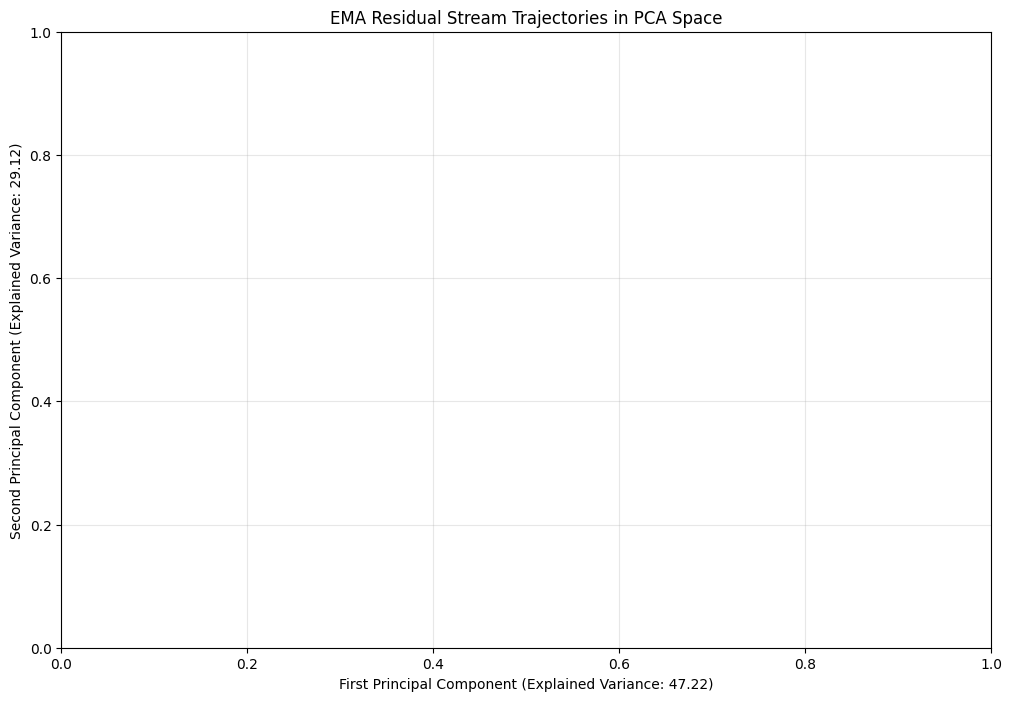

In [15]:
# Plot all projected sequences on the same 2D axis
plt.figure(figsize=(12, 8))

# Plot each projected sequence
for i, projected_seq in enumerate(projected_sequences[:10]):
    projected_seq_cpu = projected_seq.detach().cpu().numpy()
    # Color by the number remaining in sequence (sequence length decreases over time)
    colors = range(len(projected_seq_cpu),0,-1)
    scatter = plt.scatter(projected_seq_cpu[:, 0], projected_seq_cpu[:, 1], 
                         c=colors, cmap='viridis', alpha=0.7, s=20, label=f'Sequence {i+1}')

plt.xlabel(f'First Principal Component (Explained Variance: {explained_variance[0]:.2f})')
plt.ylabel(f'Second Principal Component (Explained Variance: {explained_variance[1]:.2f})')
plt.title('EMA Residual Stream Trajectories in PCA Space')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Position in Sequence')
plt.tight_layout()
plt.show()


In [16]:
n_bins = 20
def bin_y(y):
    return ((y+1).log() / torch.log(torch.tensor(1.6))).floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

In [17]:
bin_averages = {}
bin_counts = {}
for i in range(10000):
    token_ids, sequence = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_idx = get_start_pos(token_ids)
    sequence = sequence[:,start_idx:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    binned_n_remaining = bin_y(actual_n_remaining)
    
    # Group by bins and compute rolling averages
    for bin_idx in torch.unique(binned_n_remaining):
        bin_mask = binned_n_remaining == bin_idx
        bin_activations = sequence[0, bin_mask, :]  # Shape: (n_positions_in_bin, 2560)
        bin_average = bin_activations.mean(dim=0)  # Shape: (2560,)
        
        bin_key = bin_idx.item()
        if bin_key not in bin_averages:
            bin_averages[bin_key] = bin_average
            bin_counts[bin_key] = 1
        else:
            # Update rolling average
            bin_counts[bin_key] += 1
            alpha = 1.0 / bin_counts[bin_key]
            bin_averages[bin_key] = (1 - alpha) * bin_averages[bin_key] + alpha * bin_average

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/llm-progress-monitor/rollouts-big/activations/3366.pt'

In [18]:
import matplotlib.pyplot as plt

torch.Size([17, 2560])


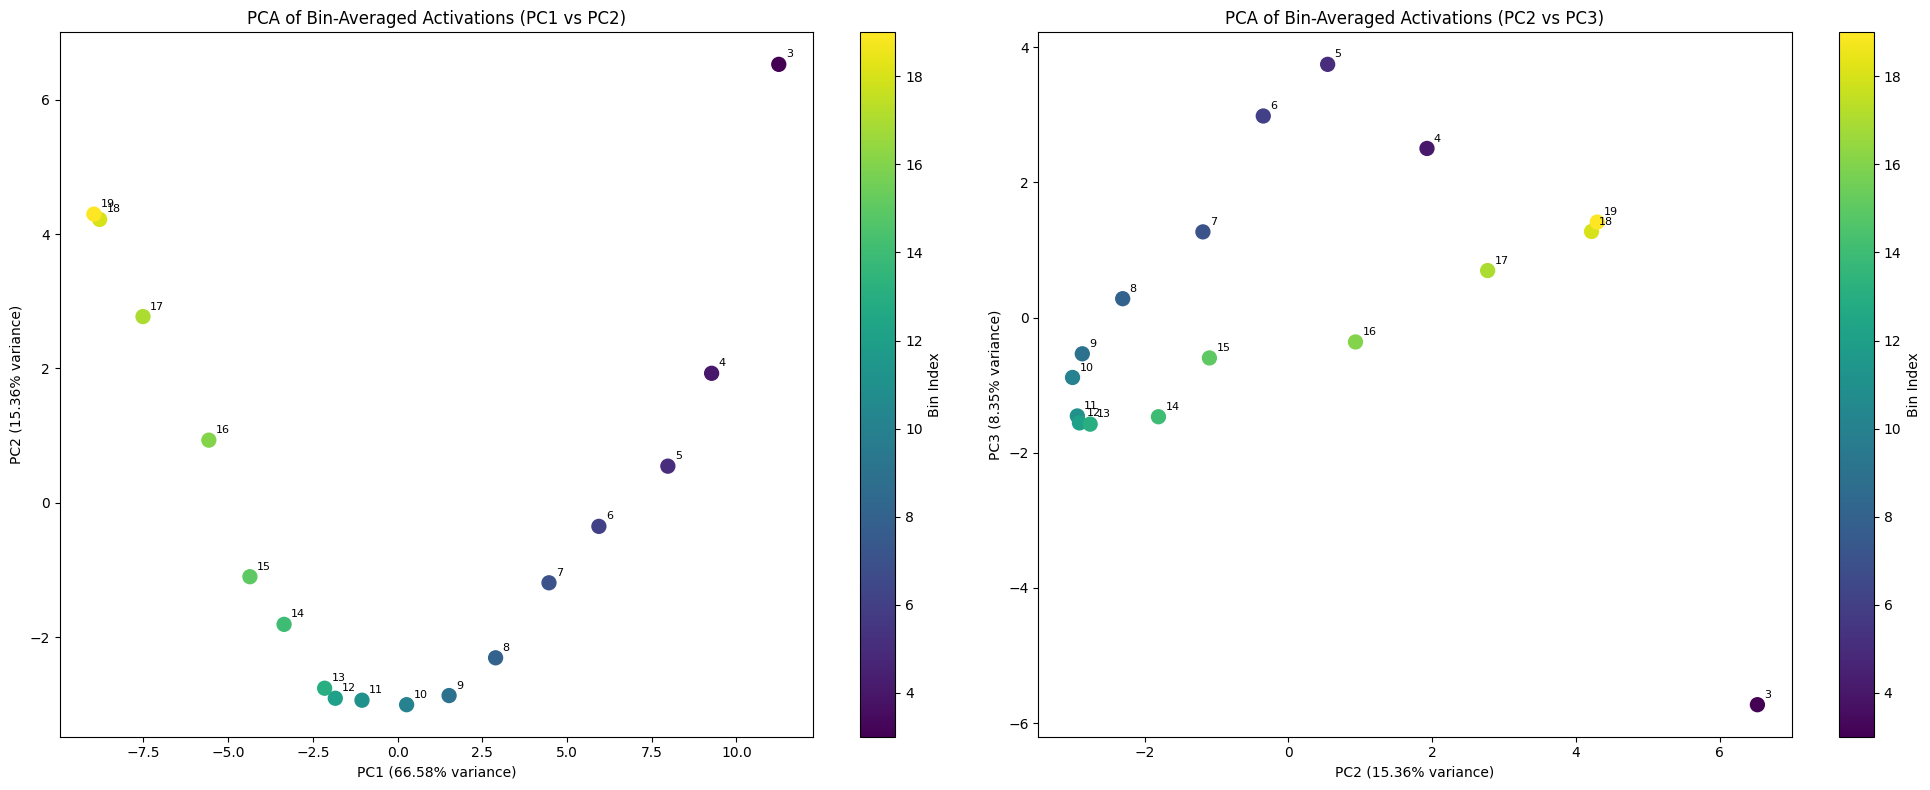

In [19]:
# Stack the bin averages and compute PCA
bin_data = torch.stack(list(bin_averages.values())[2:], dim=0).float()
print(bin_data.shape)

# Convert to numpy for sklearn PCA
bin_data_np = bin_data.cpu().numpy()

# Compute PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(bin_data_np)

# Plot the PCA results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
bin_indices = list(bin_averages.keys())[2:]  # Match the slicing used for bin_data

# PC1 vs PC2
scatter1 = ax1.scatter(pca_result[:, 0], pca_result[:, 1], c=bin_indices, cmap='viridis', s=100)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA of Bin-Averaged Activations (PC1 vs PC2)')
plt.colorbar(scatter1, ax=ax1, label='Bin Index')

# Add text labels for each point
for i, bin_idx in enumerate(bin_indices):
    ax1.annotate(f'{bin_idx}', (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# PC2 vs PC3
scatter2 = ax2.scatter(pca_result[:, 1], pca_result[:, 2], c=bin_indices, cmap='viridis', s=100)
ax2.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
ax2.set_title('PCA of Bin-Averaged Activations (PC2 vs PC3)')
plt.colorbar(scatter2, ax=ax2, label='Bin Index')

# Add text labels for each point
for i, bin_idx in enumerate(bin_indices):
    ax2.annotate(f'{bin_idx}', (pca_result[i, 1], pca_result[i, 2]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

In [44]:
def plot_sequence_on_pca(sequence_activations, title="Sequence Progress on PCA"):
    """
    Plot a sequence of activations along the PCA space, colored by progress through sequence.
    
    Args:
        sequence_activations: torch.Tensor of shape (seq_len, hidden_dim) containing activations
        title: str, title for the plot
    """
    # Handle 3D input by reshaping to 2D
    if sequence_activations.dim() == 3:
        # Reshape from (batch, seq_len, hidden_dim) to (seq_len, hidden_dim)
        # Assuming batch size is 1, take the first batch
        sequence_activations = sequence_activations[0]
    
    # Convert to numpy and apply PCA transform
    seq_data_np = sequence_activations.float().cpu().numpy()
    seq_pca_result = pca.transform(seq_data_np)
    
    # Create progress percentages (0 to 100)
    seq_len = len(sequence_activations)
    progress_percentages = np.linspace(0, 100, seq_len)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # PC1 vs PC2
    line1 = ax1.plot(seq_pca_result[:, 0], seq_pca_result[:, 1], 
                     c=progress_percentages, linewidth=2, alpha=0.8)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title(f'{title} (PC1 vs PC2)')
    
    # PC2 vs PC3
    line2 = ax2.plot(seq_pca_result[:, 1], seq_pca_result[:, 2], 
                     c=progress_percentages, linewidth=2, alpha=0.8)
    ax2.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
    ax2.set_title(f'{title} (PC2 vs PC3)')
    
    plt.tight_layout()
    plt.show()
    
    return fig


def plot_multiple_sequences_on_pca(sequences_list, labels=None, title="Multiple Sequences on PCA"):
    """
    Plot multiple sequences of activations on the same PCA space.
    
    Args:
        sequences_list: list of torch.Tensors, each of shape (seq_len, hidden_dim)
        labels: list of str, labels for each sequence (optional)
        title: str, title for the plot
    """
    if labels is None:
        labels = [f'Sequence {i+1}' for i in range(len(sequences_list))]
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Define colors for different sequences
    colors = plt.cm.tab10(np.linspace(0, 1, len(sequences_list)))
    
    for seq_idx, sequence_activations in enumerate(sequences_list):
        # Handle 3D input by reshaping to 2D
        if sequence_activations.dim() == 3:
            sequence_activations = sequence_activations[0]
        
        # Convert to numpy and apply PCA transform
        seq_data_np = sequence_activations.float().cpu().numpy()
        seq_pca_result = pca.transform(seq_data_np)
        
        # Create progress percentages (0 to 100)
        seq_len = len(sequence_activations)
        progress_percentages = np.linspace(0, 100, seq_len)
        
        # PC1 vs PC2
        ax1.plot(seq_pca_result[:, 0], seq_pca_result[:, 1], 
                 color=colors[seq_idx], linewidth=2, alpha=0.8,
                 label=labels[seq_idx])
        
        # PC2 vs PC3
        ax2.plot(seq_pca_result[:, 1], seq_pca_result[:, 2], 
                 color=colors[seq_idx], linewidth=2, alpha=0.8,
                 label=labels[seq_idx])
    
    # Set labels and titles
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title(f'{title} (PC1 vs PC2)')
    ax1.legend()
    
    ax2.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
    ax2.set_title(f'{title} (PC2 vs PC3)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig


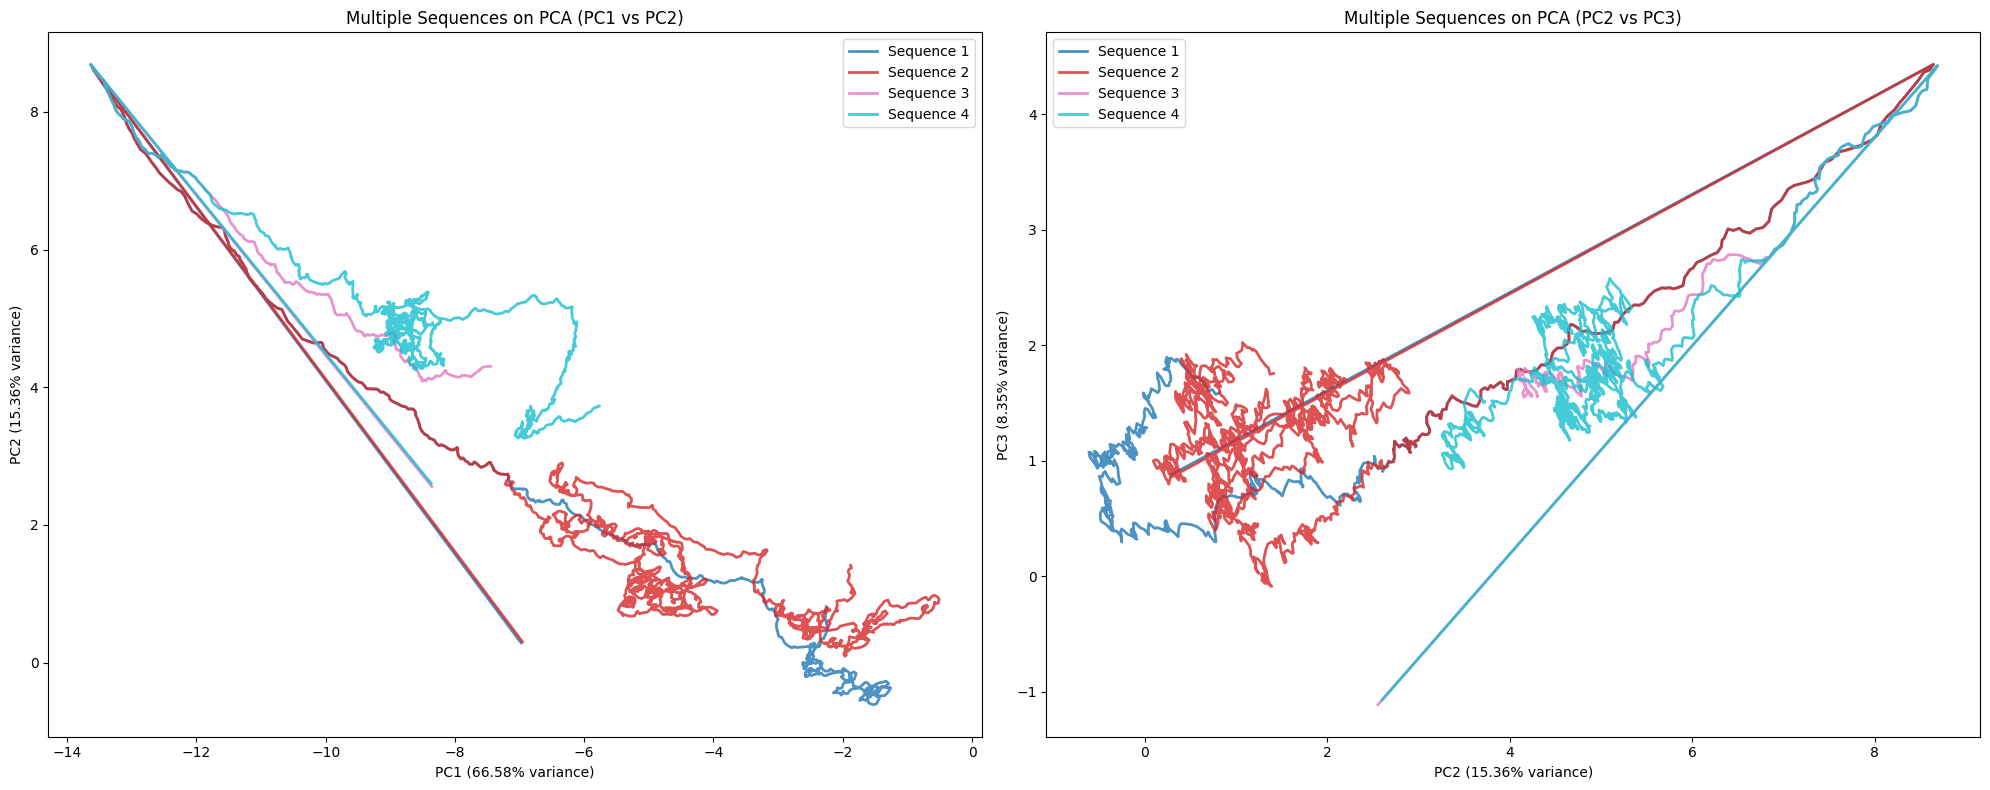

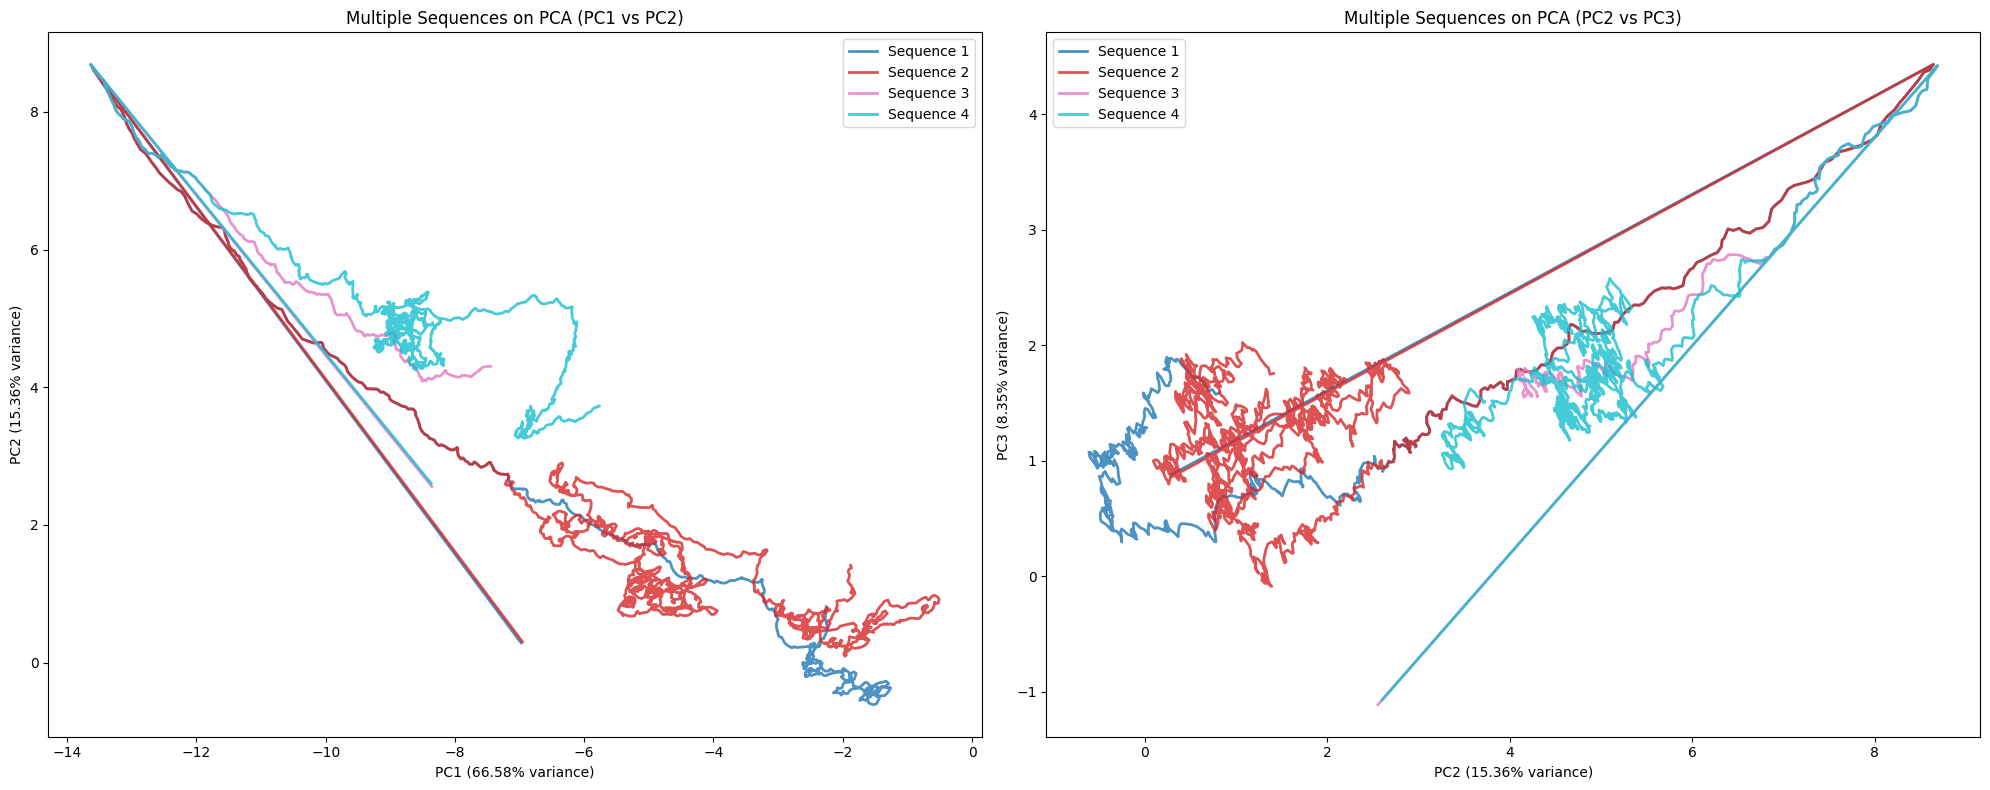

In [47]:
seqs = [ema_tensor(torch.load(f'/workspace/llm-progress-monitor/rollouts-big/activations/{i}.pt')[1].to('cuda')[:,5:][0], 0.99) for i in range(4)]
plot_multiple_sequences_on_pca(seqs)

In [28]:
seq = torch.load(f'/workspace/llm-progress-monitor/rollouts-big/activations/1.pt')[1][:,5:][0].to('cuda')
seq = ema_tensor(seq, 0.99)

In [ ]:
import numpy as np

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Compute 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(bin_data_np)

# Create the balanced log beta direction in the original space
# This represents the direction from low to high balanced log beta values
balanced_log_beta_direction = balanced_lin_to_lin_betas.float().cpu().numpy()
balanced_log_beta_direction = balanced_log_beta_direction / np.linalg.norm(balanced_log_beta_direction)

# Project the balanced log beta direction onto the 3D PCA space
balanced_log_beta_pca = pca_3d.transform(balanced_log_beta_direction.reshape(1, -1))[0]
# Normalize the projected direction
balanced_log_beta_pca = -balanced_log_beta_pca / np.linalg.norm(balanced_log_beta_pca)

# Scale the direction vector for visualization
scale_factor = np.max(np.abs(pca_result_3d)) * 0.5
balanced_log_beta_pca_scaled = balanced_log_beta_pca * scale_factor

# Create 3D scatter plot
fig = go.Figure()

# Add the bin points
fig.add_trace(go.Scatter3d(
    x=pca_result_3d[:, 0],
    y=pca_result_3d[:, 1],
    z=pca_result_3d[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=bin_indices,
        colorscale='viridis',
        colorbar=dict(
            title="Bin Index",
            x=1.1,  # Move colorbar to the right
            xanchor="left"
        ),
        showscale=True
    ),
    text=[str(idx+2) for idx in bin_indices],
    textposition="middle center",
    textfont=dict(size=10),
    name='Bin Averages'
))

# Add the balanced log beta direction as an arrow
fig.add_trace(go.Scatter3d(
    x=[0, balanced_log_beta_pca_scaled[0]],
    y=[0, balanced_log_beta_pca_scaled[1]],
    z=[0, balanced_log_beta_pca_scaled[2]],
    mode='lines+markers',
    line=dict(color='red', width=6),
    marker=dict(size=[4, 10], color='red', symbol=['circle', 'diamond']),
    name='Balanced Lin Beta Direction',
    legendgroup='direction',
    showlegend=True
))

# Add arrow annotation
fig.add_trace(go.Cone(
    x=[balanced_log_beta_pca_scaled[0]],
    y=[balanced_log_beta_pca_scaled[1]],
    z=[balanced_log_beta_pca_scaled[2]],
    u=[balanced_log_beta_pca[0]],
    v=[balanced_log_beta_pca[1]],
    w=[balanced_log_beta_pca[2]],
    colorscale='Reds',
    showscale=False,
    sizemode='absolute',
    sizeref=0.3,
    name='Direction Arrow'
))

fig.update_layout(
    title='3D PCA of Bin-Averaged Activations with Balanced Lin Beta Direction',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance)',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)'
    ),
    width=900,  # Increased width to accommodate colorbar
    height=600,
    legend=dict(
        x=0,  # Position legend on the left
        y=1,
        xanchor="left",
        yanchor="top"
    )
)
fig.show()

'''# Generate HTML
html_str = fig.to_html()
with open('html.txt', 'w') as file:
    file.write(html_str)'''


"# Generate HTML\nhtml_str = fig.to_html()\nwith open('html.txt', 'w') as file:\n    file.write(html_str)"

In [ ]:
# Convert bin averages to tensor
bin_averages_tensor = torch.tensor(bin_data_np, dtype=torch.float32)
print(f"Bin averages tensor shape: {bin_averages_tensor.shape}")


In [ ]:
# Compute differences between adjacent bins
bin_differences = bin_averages_tensor[1:] - bin_averages_tensor[:-1]
print(f"Bin differences tensor shape: {bin_differences.shape}")
print(f"Number of differences: {len(bin_differences)}")


In [ ]:
# Compute cosine similarity matrix of bin differences
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
cosine_sim_matrix = cosine_similarity(bin_differences.numpy())

# Create the plot
plt.figure(figsize=(10, 8))
plt.imshow(cosine_sim_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix of Bin Differences')
plt.xlabel('Bin Difference Index')
plt.ylabel('Bin Difference Index')
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B")



In [ ]:
tokenizer.encode("</think>")

[151668]